# Análisis Exploratorio de Datos (EDA): Carcinoma Papilar de Tiroides (TCGA-THCA)
En este notebook realizaremos un análisis exhaustivo del perfil clínico y genómico de pacientes con carcinoma de tiroides. El objetivo es identificar patrones que diferencien los grupos de pacientes y explorar cómo la expresión de ciertos genes se relaciona con el avance de la enfermedad.

In [3]:
import pandas as pd
import numpy as np

# Cargar datos clínicos (503 samples x 15 attributes)
df_clinical = pd.read_table('Clinical_Phenotype.tsi', index_col=0)
df_clinical = df_clinical.T # Lo trasponemos para tener muestras en filas

# Cargar datos RNA-seq (Genes x Samples)
df_rna = pd.read_table('RNAseq_Gene_level.cct', index_col=0)
df_rna = df_rna.T  # Lo trasponemos también, así ambos tienen la misma estructura

In [4]:
print(f"Dimensiones Clínicas: {df_clinical.shape}")
print(f"Dimensiones RNA-seq: {df_rna.shape}")
print("Información del archivo clínico:")
print(df_clinical.info())

# Ver las primeras filas
display(df_clinical.head())
display(df_rna.iloc[:5, :5]) # Solo las primeras 5x5 para no saturar la pantalla

Dimensiones Clínicas: (503, 16)
Dimensiones RNA-seq: (501, 19927)
Información del archivo clínico:
<class 'pandas.core.frame.DataFrame'>
Index: 503 entries, TCGA.BJ.A290 to TCGA.E8.A418
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   years_to_birth         503 non-null    object
 1   Tumor_purity           495 non-null    object
 2   pathologic_stage       501 non-null    object
 3   pathology_T_stage      501 non-null    object
 4   pathology_N_stage      453 non-null    object
 5   pathology_M_stage      289 non-null    object
 6   histological_type      503 non-null    object
 7   number_of_lymph_nodes  389 non-null    object
 8   gender                 503 non-null    object
 9   radiation_therapy      487 non-null    object
 10  residual_tumor         441 non-null    object
 11  race                   411 non-null    object
 12  ethnicity              400 non-null    object
 13  overall_sur

attrib_name,years_to_birth,Tumor_purity,pathologic_stage,pathology_T_stage,pathology_N_stage,pathology_M_stage,histological_type,number_of_lymph_nodes,gender,radiation_therapy,residual_tumor,race,ethnicity,overall_survival,status,overallsurvival
TCGA.BJ.A290,70,0.9164,stageiii,t3,n1,m0,thyroidpapillarycarcinoma-tallcell(>=50%tallce...,3,male,yes,NaN,white,nothispanicorlatino,919,0,"919,0"
TCGA.BJ.A291,56,0.9253,stagei,t1,n0,m0,thyroidpapillarycarcinoma-classical/usual,0,female,yes,NaN,white,nothispanicorlatino,696,0,"696,0"
TCGA.BJ.A45K,33,0.9475,stagei,t2,n0,m0,thyroidpapillarycarcinoma-classical/usual,0,male,yes,NaN,white,nothispanicorlatino,705,0,"705,0"
TCGA.CE.A13K,30,0.9431,stagei,t3,n1,m0,thyroidpapillarycarcinoma-classical/usual,2,female,no,r0,asian,nothispanicorlatino,385,0,"385,0"
TCGA.DE.A0XZ,65,0.8013,stageiii,t1,n1,m0,thyroidpapillarycarcinoma-classical/usual,5,female,yes,r0,white,nothispanicorlatino,1090,0,"1090,0"


attrib_name,A1BG,A1CF,A2BP1,A2LD1,A2ML1
TCGA.4C.A93U,6.7783,0.0000,0.0000,6.3423,0.5686
TCGA.BJ.A0YZ,7.9814,0.5023,4.6288,6.0307,0.8742
TCGA.BJ.A0Z0,7.1232,0.0000,2.4177,5.4087,1.3670
TCGA.BJ.A0Z2,8.4094,0.0000,4.7105,6.7106,0.0000
TCGA.BJ.A0Z3,6.7996,0.0000,1.6286,6.5277,0.0000


## Preprocesamiento y Control de Calidad de Datos (RNA-seq & Clínica)
Antes de realizar el análisis estadístico, es fundamental asegurar la integridad y la calidad de los datos. Este proceso se divide en tres fases críticas:
1. Alineamiento de Muestras (Sample Matching)
Los datos provienen de dos fuentes distintas: un archivo de fenotipo clínico (.tsi) y uno de expresión génica (.cct)
- Orientación: Hemos traspuesto ambos DataFrames para obtener una mejor observación.
- Sincronización: Dado que existen 503 muestras clínicas y 501 genéticas, se realiza un Inner Join basado en el identificador único del paciente (attrib_name, presente en ambos archivos de datos). Esto garantiza que solo analizaremos sujetos que cuenten con información completa en ambas ómicas.
2. Interpretación de la Escala Logarítmica
Los valores de RNA-seq están normalizados en escala $\log_2(x + 1)$. Esta transformación es estándar en bioinformática porque:
-Comprime el rango dinámico: Permite comparar genes con niveles de expresión masivos (ej. $13-14$ en escala log) frente a genes de baja abundancia (ej. $1-2$).
- Normaliza la varianza: Mitiga el sesgo de los valores extremos, facilitando la aplicación de modelos lineales y pruebas estadísticas.
3. Criterios de Filtrado de Genes
Para reducir el ruido y aumentar el poder estadístico, filtramos los 19,927 genes originales bajo dos criterios:
- Filtro de Expresión Mínima: Se eliminan genes con una media inferior a 0.5, ya que suelen representar ruido de fondo o genes "apagados" sin relevancia biológica en este tejido.
- Filtro de Varianza (Información): Se descartan los genes con baja variabilidad (inferior al percentil 25). Un gen que no cambia entre pacientes no sirve como biomarcador ni ayuda a diferenciar estadios clínicos.

In [5]:
# 3. FILTRADO DE GENES
print(f"Genes antes del filtrado: {df_rna.shape[1]}") #uso el 1 para que solo me ofrezca el número de columnas, que es el que se va a modificar

# A. Filtro de expresión mínima (Media > 0.5)
mascara_media = df_rna.mean() > 0.5

# B. Filtro de Variabilidad (Varianza > Percentil 25)
mascara_varianza = df_rna.var() > df_rna.var().quantile(0.25)

# Aplicamos ambos filtros al dataframe de RNA directamente
df_rna_filtrado = df_rna.loc[:, mascara_media & mascara_varianza]

print(f"Genes después del filtrado: {df_rna_filtrado.shape[1]}")

Genes antes del filtrado: 19927
Genes después del filtrado: 14058


In [6]:
# 4. ALINEAMIENTO (Merge)
df_combined = pd.merge(df_clinical, df_rna_filtrado, left_index=True, right_index=True, how='inner')
# how='inner' elimina automáticamente las 2 muestras sobrantes de la clínica
display(df_combined)

attrib_name,years_to_birth,Tumor_purity,pathologic_stage,pathology_T_stage,pathology_N_stage,pathology_M_stage,histological_type,number_of_lymph_nodes,gender,radiation_therapy,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22
TCGA.BJ.A290,70,0.9164,stageiii,t3,n1,m0,thyroidpapillarycarcinoma-tallcell(>=50%tallce...,3,male,yes,...,7.7473,8.3445,5.4073,8.3531,5.1289,10.7296,11.5958,9.7266,10.0651,8.2933
TCGA.BJ.A291,56,0.9253,stagei,t1,n0,m0,thyroidpapillarycarcinoma-classical/usual,0,female,yes,...,5.9979,6.5599,5.4196,7.8035,4.2978,10.0419,10.9372,9.7396,9.0237,9.3920
TCGA.BJ.A45K,33,0.9475,stagei,t2,n0,m0,thyroidpapillarycarcinoma-classical/usual,0,male,yes,...,6.8550,7.6329,6.2115,8.2636,4.8138,10.0425,11.0905,10.7769,9.5262,3.4051
TCGA.CE.A13K,30,0.9431,stagei,t3,n1,m0,thyroidpapillarycarcinoma-classical/usual,2,female,no,...,6.9909,5.7142,6.0066,8.2334,3.8446,10.3619,12.1129,10.2350,9.3924,9.2139
TCGA.DE.A0XZ,65,0.8013,stageiii,t1,n1,m0,thyroidpapillarycarcinoma-classical/usual,5,female,yes,...,7.5596,7.4160,6.0106,8.2551,4.2707,10.4566,11.3216,10.6043,9.9314,7.5806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA.MK.A4N6,35,0.8064,stagei,t3,n1,m0,thyroidpapillarycarcinoma-classical/usual,40,male,yes,...,7.5719,7.5342,5.2254,8.5422,5.9968,11.4576,12.1779,10.2055,9.4912,8.6888
TCGA.MK.A4N7,20,0.97,stagei,t2,n0,m0,thyroidpapillarycarcinoma-classical/usual,0,female,yes,...,7.3318,6.8214,5.9486,8.6866,4.0438,10.6519,11.4812,10.1791,9.8751,8.7327
TCGA.MK.A4N9,41,0.9015,stagei,t3,n1,m0,thyroidpapillarycarcinoma-classical/usual,1,female,yes,...,7.3517,6.6130,5.7360,8.2884,2.8934,10.4098,11.9094,10.3361,9.6806,8.3119
TCGA.QD.A8IV,50,0.9133,stageiv,t3,n1,NaN,thyroidpapillarycarcinoma-classical/usual,15,female,yes,...,6.9116,7.5259,6.2881,8.8844,7.4703,10.5517,10.1668,10.5275,9.8784,9.5143


In [10]:
df_combined.loc[:, "years_to_birth":"radiation_therapy"].info()

<class 'pandas.core.frame.DataFrame'>
Index: 501 entries, TCGA.BJ.A290 to TCGA.E8.A418
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   years_to_birth         501 non-null    object
 1   Tumor_purity           493 non-null    object
 2   pathologic_stage       499 non-null    object
 3   pathology_T_stage      499 non-null    object
 4   pathology_N_stage      451 non-null    object
 5   pathology_M_stage      288 non-null    object
 6   histological_type      501 non-null    object
 7   number_of_lymph_nodes  387 non-null    object
 8   gender                 501 non-null    object
 9   radiation_therapy      485 non-null    object
dtypes: object(10)
memory usage: 43.1+ KB


In [ ]:
ANÁLISIS DE VARIABLES CLÍNICAS UNIVARIANTE

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

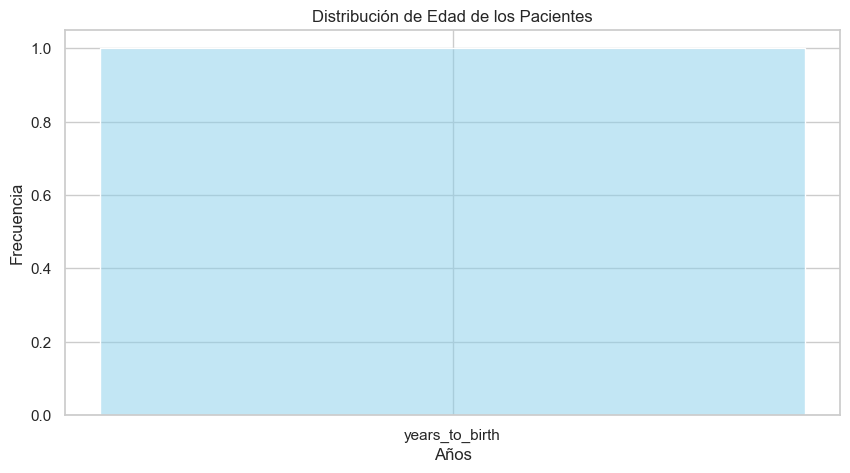

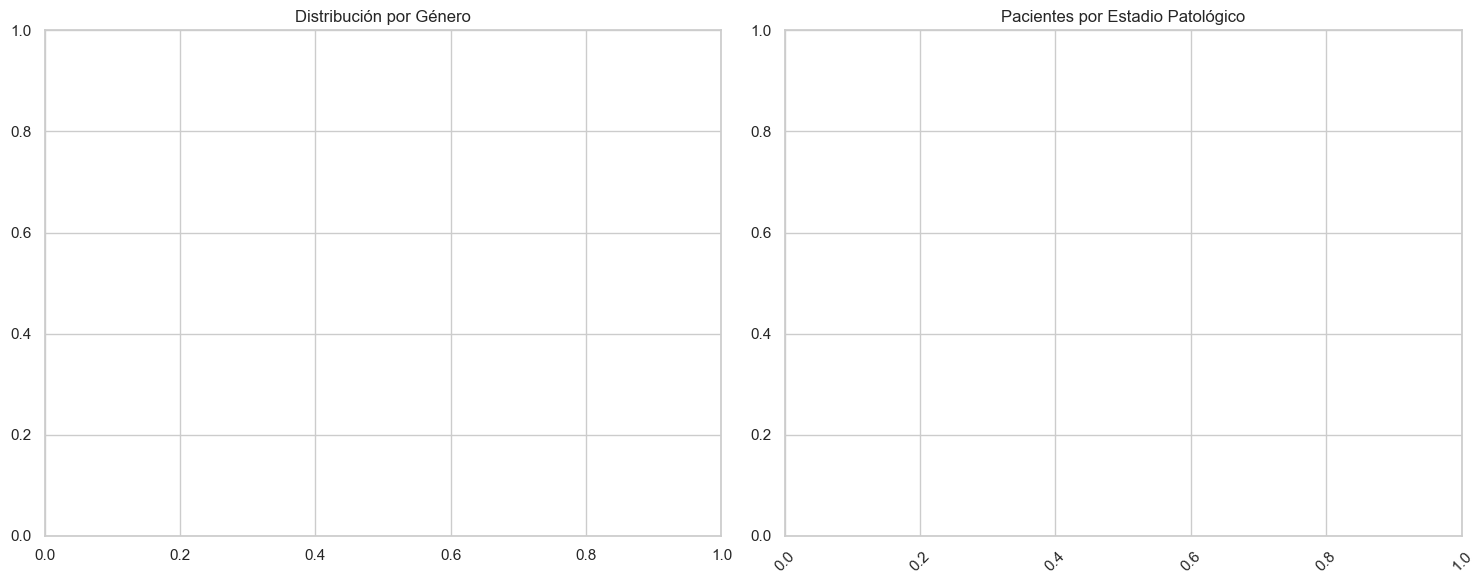

In [13]:
# Configuración estética de los gráficos
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Distribución de la EDAD
plt.figure(figsize=(10, 5))
sns.histplot(['years_to_birth'], kde=True, color='skyblue')
plt.title('Distribución de Edad de los Pacientes')
plt.xlabel('Años')
plt.ylabel('Frecuencia')
plt.show()

# Distribución de GÉNERO y ESTADIO PATOLÓGICO
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].set_title('Distribución por Género')

# Ordenamos
stage_order = ['stagei', 'stageii', 'stageiii', 'stageiv']
sns.countplot

axes[1].set_title('Pacientes por Estadio Patológico')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

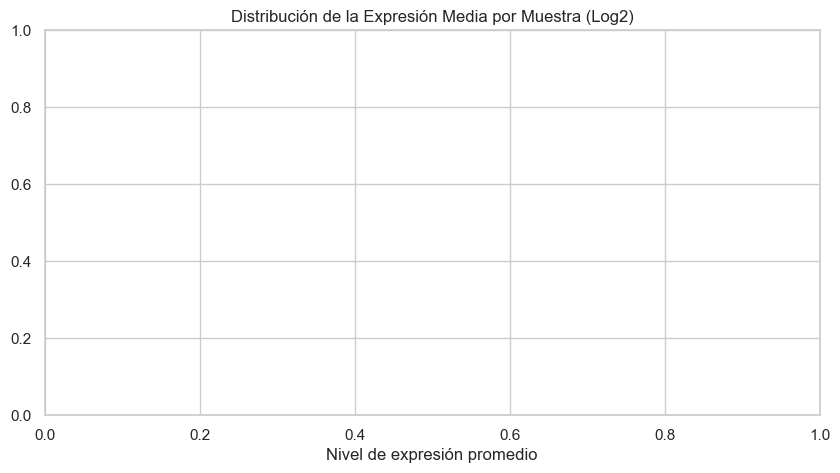

Genes con mayor variabilidad (potenciales diferenciadores):


In [31]:

# Calculamos la media de expresión de todos los genes por cada muestra
plt.figure(figsize=(10, 5))
plt.title('Distribución de la Expresión Media por Muestra (Log2)')
plt.xlabel('Nivel de expresión promedio')
plt.show()

# Identificar los 5 genes con mayor varianza (potenciales biomarcadores)
print("Genes con mayor variabilidad (potenciales diferenciadores):")


In [30]:
for col in ['pathology_T_stage', 'pathology_N_stage', 'radiation_therapy']:
    print(f"\nFrecuencias para {col}:")
  


Frecuencias para pathology_T_stage:

Frecuencias para pathology_N_stage:

Frecuencias para radiation_therapy:


In [ ]:
ANÁLISIS BIVARIANTE


In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

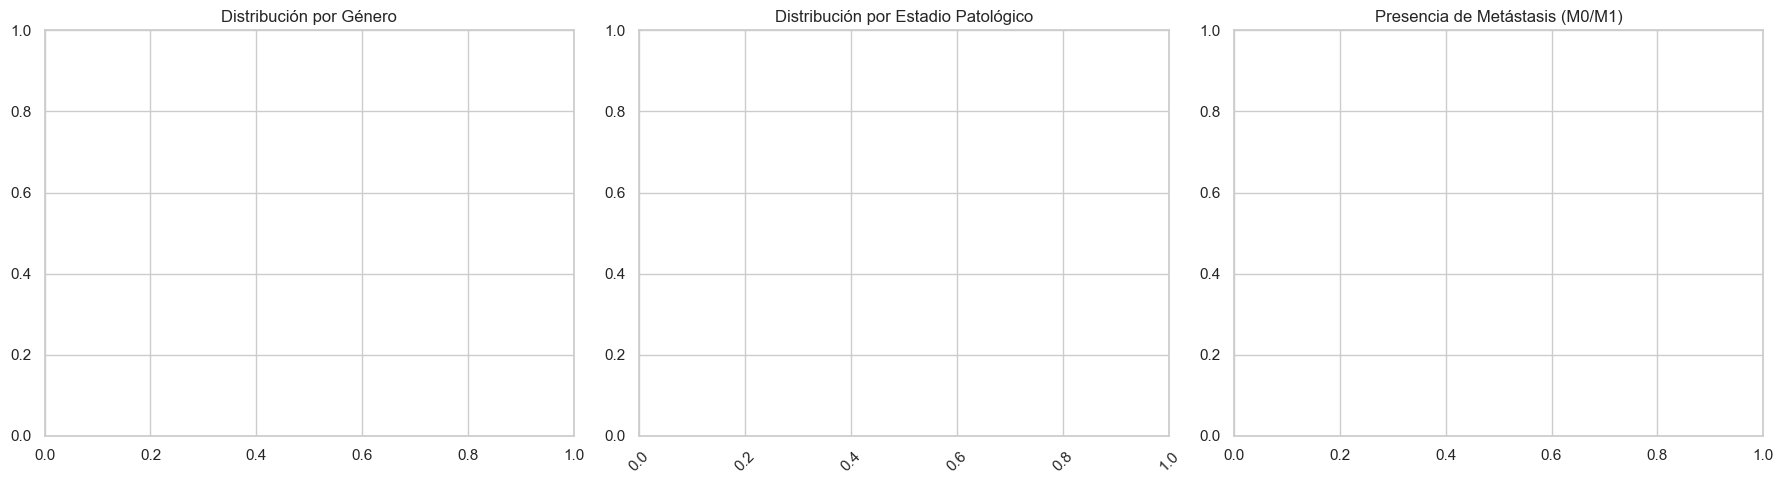

In [42]:
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (15, 5)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].set_title('Distribución por Género')
order_stage = ['stagei', 'stageii', 'stageiii', 'stageiv']
axes[1].set_title('Distribución por Estadio Patológico')
axes[1].tick_params(axis='x', rotation=45)
axes[2].set_title('Presencia de Metástasis (M0/M1)')

plt.tight_layout()
plt.show()

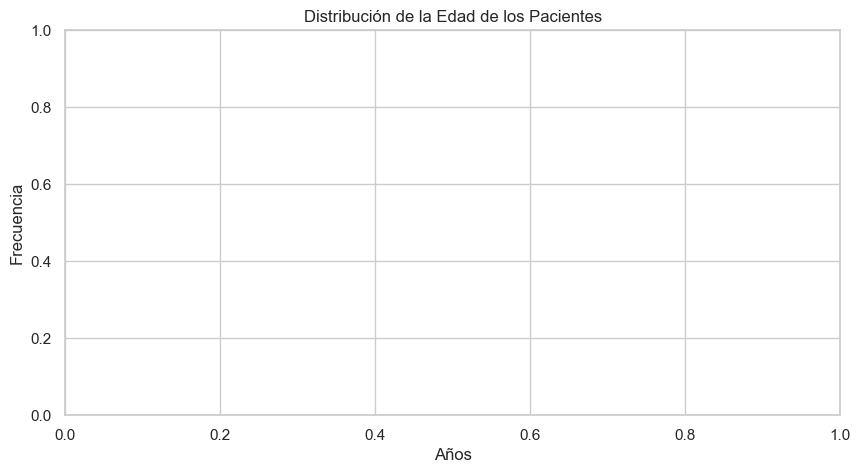

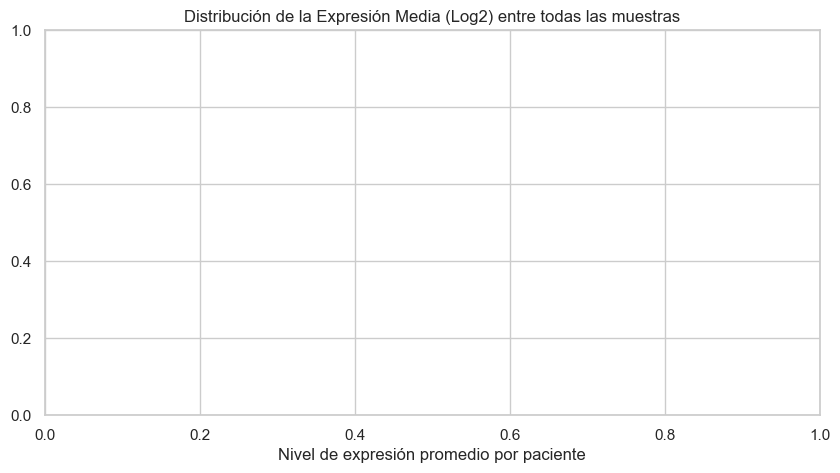

In [46]:
plt.figure(figsize=(10, 5))
plt.title('Distribución de la Edad de los Pacientes')
plt.xlabel('Años')
plt.ylabel('Frecuencia')
plt.show()

plt.figure(figsize=(10, 5))
plt.title('Distribución de la Expresión Media (Log2) entre todas las muestras')
plt.xlabel('Nivel de expresión promedio por paciente')
plt.show()

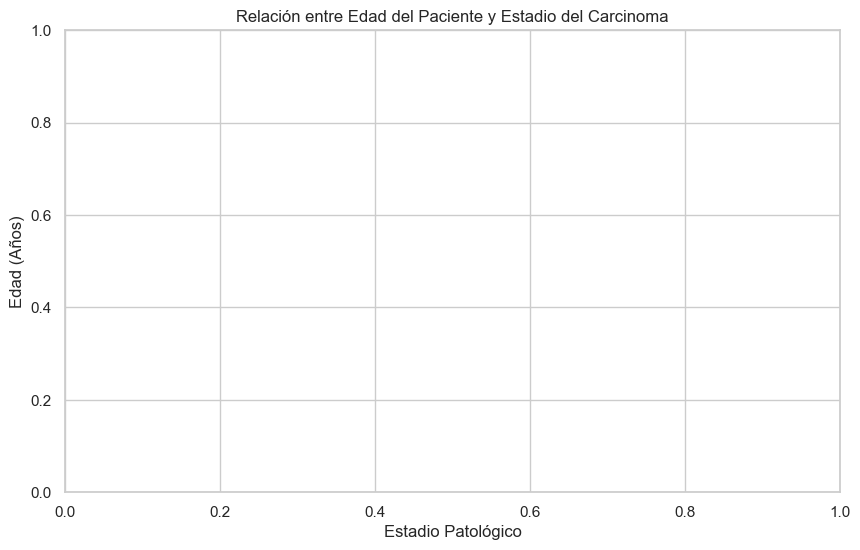

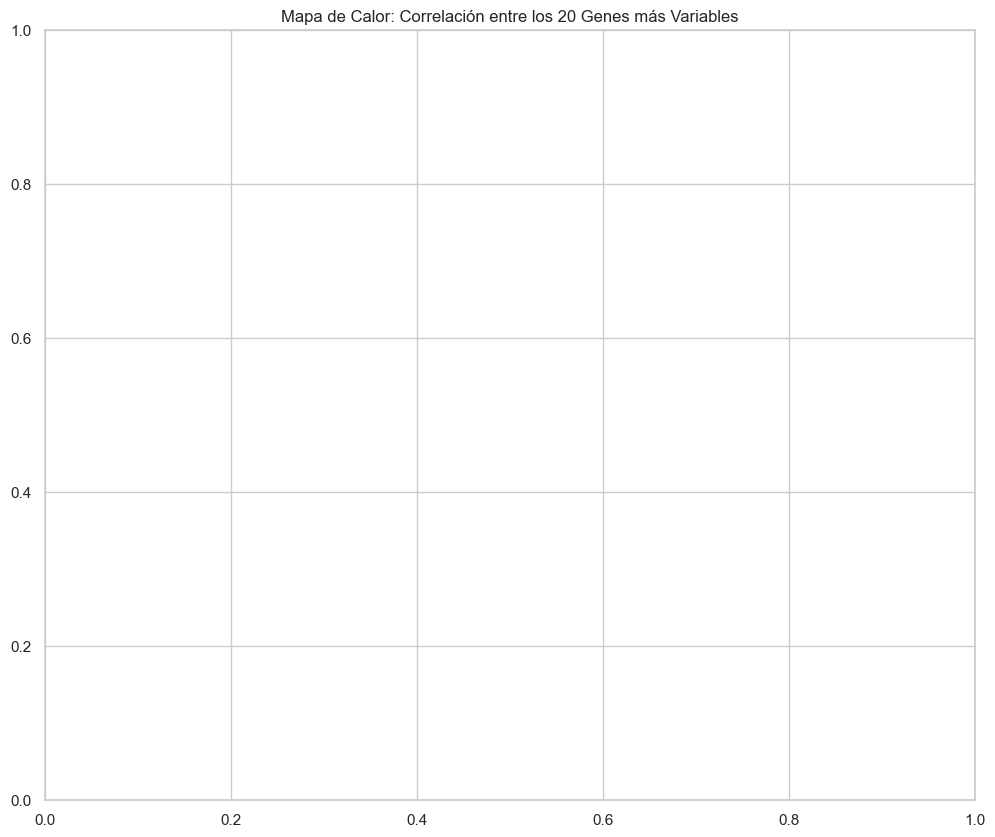

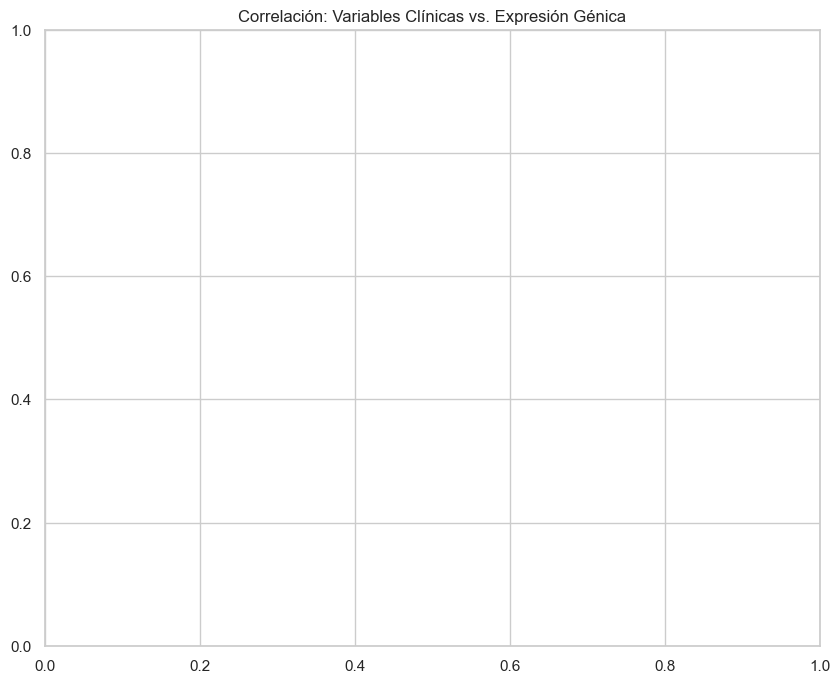

In [78]:
plt.figure(figsize=(10, 6))

plt.title('Relación entre Edad del Paciente y Estadio del Carcinoma')
plt.xlabel('Estadio Patológico')
plt.ylabel('Edad (Años)')
plt.show()

plt.figure(figsize=(12, 10))
plt.title('Mapa de Calor: Correlación entre los 20 Genes más Variables')
plt.show()

clinicas_num = ['years_to_birth', 'Tumor_purity']

plt.figure(figsize=(10, 8))
           
plt.title('Correlación: Variables Clínicas vs. Expresión Génica')
plt.show()
